### All Data: Consensus Genotype

* The following notebook is trained on data generated from revised R script [Oct 12 2017]
    * Exact Match [1] and Homozygous [0] Reference data points
    * Removed all data points with Gtcons and GTconswithoutXX -1
* 5k randomly selected deletions test data was also processed through same R script
* Balanced Training Set for GTcons labels:
    * 200 Hom Var
    * 200 Hom Ref
    * 200 Het Var
* **Train/Prediction Label:** consensus genotype


In [1]:
"""
Imports
"""
import pandas as pd
import numpy as np
import graphviz
import io
from fancyimpute import KNN
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import LeaveOneOut
from scipy.stats import ks_2samp
from scipy import stats
from matplotlib import pyplot
from sklearn import preprocessing
from scipy.linalg import svd
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA as sklearnPCA
import plotly.plotly as py
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import f1_score, precision_score
from sklearn import preprocessing
from ggplot import *
from bokeh.charts import TimeSeries
from bokeh.models import HoverTool
from bokeh.plotting import show
from bokeh.charts import Scatter, Histogram, output_file, show
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.io import output_notebook
from bokeh.charts import Bar, output_file, show
import bokeh.palettes as palettes
from bokeh.models import HoverTool, BoxSelectTool, Legend
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# NOTE : if LocalOutlierFactor does not install try running : 
# pip install scikit-learn --upgrade

In [3]:
# Import Training Data
# SVanalyzer generated training data
df_train = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct272017_ML_w_AllTech/data/train_test_data/train_data_min1.csv')
df_train_2 = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct272017_ML_w_AllTech/data/train_test_data/train_data_min1.csv')
df_train.rename(columns={'size': 'Size'}, inplace=True)
df_train.head(1)

,chrom,id,sample,start,end,type,SVtype,Size,Ill250.GT,Ill250.alt_alnScore_mean,...,tandemrep_pct,Label,GTconflict,GTcons,GTconswithoutIll250.GT,GTconswithoutIll300x.GT,GTconswithoutIllMP.GT,GTconswithoutTenX.GT,GTconswithoutpacbio.GT,GTsupp
0,1,23,HG002,72766323,72811839,Deletion,Deletion,-45516,1.0,977.7,...,0.059979,1,-1,1,1,1,1,1,1,3


In [4]:
train_set = pd.DataFrame()
train_set = df_train_2

In [5]:
train_set['GTcons'].replace(0, 'Homozygous_Reference', inplace=True)
train_set['GTcons'].replace(1, 'Heterozygous_Variant', inplace=True)
train_set['GTcons'].replace(2, 'Homozygous_Variant', inplace=True)

<a id='imbalance'></a>

In [6]:
pd.value_counts(train_set['GTcons'].values, sort=False)

Homozygous_Reference    971
Homozygous_Variant      200
Heterozygous_Variant    623
dtype: int64

** NOTE: Imbalanced classes in original training dataset. The following loads dataset with equal examples of each class **

In [7]:
# Import Training Data
# SVanalyzer generated training data
df_train = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct272017_ML_w_AllTech/data/train_test_data/train_data_balanced.csv')
df_train_2 = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct272017_ML_w_AllTech/data/train_test_data/train_data_balanced.csv')
df_train.rename(columns={'size': 'Size'}, inplace=True)
df_train.head(1)

,chrom,id,sample,start,end,type,SVtype,Size,Ill250.GT,Ill250.alt_alnScore_mean,...,tandemrep_pct,Label,GTconflict,GTcons,GTconswithoutIll250.GT,GTconswithoutIll300x.GT,GTconswithoutIllMP.GT,GTconswithoutTenX.GT,GTconswithoutpacbio.GT,GTsupp
0,1,21,HG002,65326531,65326651,Deletion,Deletion,-120,0.0,954.0,...,1.0,1,-1,0,0,0,0,0,0,4


In [8]:
train_set = pd.DataFrame()
train_set = df_train_2

In [9]:
train_set['GTcons'].replace(0, 'Homozygous_Reference', inplace=True)
train_set['GTcons'].replace(1, 'Heterozygous_Variant', inplace=True)
train_set['GTcons'].replace(2, 'Homozygous_Variant', inplace=True)

<a id='imbalance'></a>

In [10]:
pd.value_counts(train_set['GTcons'].values, sort=False)

Homozygous_Variant      200
Heterozygous_Variant    200
Homozygous_Reference    200
dtype: int64

In [11]:
# Train the model only on the rows that have an Exact Match or Homozygous Reference Label
# This step removes any row that has in 'Inaccurate Call' label
df_train = df_train[(df_train['Label'] == 1) | (df_train['Label'] == 0)]
df_train_2 = df_train_2[(df_train_2['Label'] == 1) | (df_train_2['Label'] == 0)]

In [12]:
# There are only Exact Match [1] and Homozygous Reference Labels [0]
pd.value_counts(df_train['Label'].values, sort=False)

0    164
1    436
dtype: int64

<a id='hom_ref'></a>

In [13]:
# Import Test Data
# SVanalyzer generated training data
df_test = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct272017_ML_w_AllTech/data/train_test_data/test_data_min1.csv')
df_test_2 = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct272017_ML_w_AllTech/data/train_test_data/test_data_min1.csv')
df_test.rename(columns={'size': 'Size'}, inplace=True)
df_test.head(1)

,chrom,id,Size,sample,start,end,type,SVtype,Ill250.GT,Ill250.alt_alnScore_mean,...,tandemrep_cnt,tandemrep_pct,GTconflict,GTcons,GTconswithoutIll250.GT,GTconswithoutIll300x.GT,GTconswithoutIllMP.GT,GTconswithoutTenX.GT,GTconswithoutpacbio.GT,GTsupp
0,1,859,-115,HG002,37568322,37568587,Insertion,Deletion,0.0,0.0,...,3,0.818868,-1,0,0,0,0,0,0,4


In [14]:
# Store header names in lists and find names that are NOT contained in BOTH lists
c = list(df_train.columns.values)
d = list(df_test.columns.values)
set(c) - set(d)

{'Label'}

In [15]:
### Drop columns that are not shared by both dataframes
df_train.drop(['Label'], axis=1, inplace = True)
df_train.drop(['GTconswithoutIll300x.GT'], axis=1, inplace = True)
df_train.drop(['GTconswithoutIll250.GT'], axis=1, inplace = True)
df_train.drop(['GTconswithoutIllMP.GT'], axis=1, inplace = True)
df_train.drop(['GTconswithoutTenX.GT'], axis=1, inplace = True)
df_train.drop(['GTconswithoutpacbio.GT'], axis=1, inplace = True)
df_train.drop(['Ill300x.GT'], axis=1, inplace = True)
df_train.drop(['Ill250.GT'], axis=1, inplace = True)
df_train.drop(['IllMP.GT'], axis=1, inplace = True)
df_train.drop(['TenX.GT'], axis=1, inplace = True)
df_train.drop(['pacbio.GT'], axis=1, inplace = True)
df_train.drop(['GTconflict'], axis=1, inplace = True)
df_train.drop(['GTsupp'], axis=1, inplace = True)
df_train.drop(['sample'], axis=1, inplace = True)
df_train.drop(['SVtype'], axis=1, inplace = True)
df_train.drop(['type'], axis=1, inplace = True)
df_train.drop(['id'], axis=1, inplace = True)

In [16]:
df_train.head(1)

,chrom,start,end,Size,Ill250.alt_alnScore_mean,Ill250.alt_alnScore_std,Ill250.alt_count,Ill250.alt_insertSize_mean,Ill250.alt_insertSize_std,Ill250.alt_reason_alignmentScore,...,pacbio.ref_insertSize_mean,pacbio.ref_insertSize_std,pacbio.ref_reason_alignmentScore,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,GTcons
0,1,65326531,65326651,-120,954.0,0.0,1.0,445.0,0.0,1.0,...,11277.83333,4197.626206,54.0,0,0,0,0.0,1,1.0,0


In [17]:
df_train['chrom'].replace('X', 23, inplace=True)
df_train['chrom'].replace('Y', 24, inplace=True)
df_test['chrom'].replace('X', 23, inplace=True)
df_test['chrom'].replace('Y', 24, inplace=True)

In [18]:
# Store header names in lists and find names that are NOT contained in BOTH lists
c = list(df_train.columns.values)
d = list(df_test.columns.values)
set(d) - set(c)

{'GTconflict',
 'GTconswithoutIll250.GT',
 'GTconswithoutIll300x.GT',
 'GTconswithoutIllMP.GT',
 'GTconswithoutTenX.GT',
 'GTconswithoutpacbio.GT',
 'GTsupp',
 'Ill250.GT',
 'Ill250.amb_reason_insertSizeScore_insertSizeScore',
 'Ill250.amb_reason_insertSizeScore_orientation',
 'Ill300x.GT',
 'Ill300x.amb_reason_alignmentScore_insertSizeScore',
 'Ill300x.amb_reason_insertSizeScore_orientation',
 'Ill300x.amb_reason_orientation_insertSizeScore',
 'IllMP.GT',
 'IllMP.amb_reason_orientation_insertSizeScore',
 'SVtype',
 'TenX.GT',
 'TenX.HP1_amb_reason_insertSizeScore_insertSizeScore',
 'TenX.HP1_amb_reason_insertSizeScore_orientation',
 'TenX.HP1_amb_reason_orientation_insertSizeScore',
 'TenX.HP1_ref_reason_insertSizeScore',
 'TenX.HP2_amb_reason_insertSizeScore_insertSizeScore',
 'TenX.HP2_amb_reason_insertSizeScore_orientation',
 'TenX.HP2_amb_reason_orientation_insertSizeScore',
 'TenX.HP2_ref_reason_insertSizeScore',
 'id',
 'pacbio.GT',
 'sample',
 'type'}

In [19]:
### Drop columns that are not shared by both dataframes
df_test.drop(['Ill300x.amb_reason_alignmentScore_insertSizeScore'], axis=1, inplace = True)
df_test.drop(['Ill300x.amb_reason_insertSizeScore_orientation'], axis=1, inplace = True)
df_test.drop(['Ill300x.amb_reason_orientation_insertSizeScore'], axis=1, inplace = True)
df_test.drop(['Ill250.amb_reason_insertSizeScore_insertSizeScore'], axis=1, inplace = True)
df_test.drop(['Ill250.amb_reason_insertSizeScore_orientation'], axis=1, inplace = True)
df_test.drop(['IllMP.amb_reason_orientation_insertSizeScore'], axis=1, inplace = True)
df_test.drop(['TenX.HP1_amb_reason_insertSizeScore_insertSizeScore'], axis=1, inplace = True)
df_test.drop(['TenX.HP1_amb_reason_insertSizeScore_orientation'], axis=1, inplace = True)
df_test.drop(['TenX.HP1_amb_reason_orientation_insertSizeScore'], axis=1, inplace = True)
df_test.drop(['TenX.HP1_ref_reason_insertSizeScore'], axis=1, inplace = True)
df_test.drop(['TenX.HP2_amb_reason_insertSizeScore_insertSizeScore'], axis=1, inplace = True)
df_test.drop(['TenX.HP2_amb_reason_insertSizeScore_orientation'], axis=1, inplace = True)
df_test.drop(['TenX.HP2_amb_reason_orientation_insertSizeScore'], axis=1, inplace = True)
df_test.drop(['TenX.HP2_ref_reason_insertSizeScore'], axis=1, inplace = True)
df_test.drop(['GTconswithoutIll300x.GT'], axis=1, inplace = True)
df_test.drop(['GTconswithoutIll250.GT'], axis=1, inplace = True)
df_test.drop(['GTconswithoutIllMP.GT'], axis=1, inplace = True)
df_test.drop(['GTconswithoutTenX.GT'], axis=1, inplace = True)
df_test.drop(['GTconswithoutpacbio.GT'], axis=1, inplace = True)
df_test.drop(['Ill300x.GT'], axis=1, inplace = True)
df_test.drop(['Ill250.GT'], axis=1, inplace = True)
df_test.drop(['IllMP.GT'], axis=1, inplace = True)
df_test.drop(['TenX.GT'], axis=1, inplace = True)
df_test.drop(['pacbio.GT'], axis=1, inplace = True)
df_test.drop(['GTcons'], axis=1, inplace = True)
df_test.drop(['GTconflict'], axis=1, inplace = True)
df_test.drop(['GTsupp'], axis=1, inplace = True)
df_test.drop(['sample'], axis=1, inplace = True)
df_test.drop(['SVtype'], axis=1, inplace = True)
df_test.drop(['type'], axis=1, inplace = True)
df_test.drop(['id'], axis=1, inplace = True)

***
Impute missing values using KNN
***

In [20]:
# Store training data in a new variable which will be converted to a matrix
X = df_train
X.head(3)

,chrom,start,end,Size,Ill250.alt_alnScore_mean,Ill250.alt_alnScore_std,Ill250.alt_count,Ill250.alt_insertSize_mean,Ill250.alt_insertSize_std,Ill250.alt_reason_alignmentScore,...,pacbio.ref_insertSize_mean,pacbio.ref_insertSize_std,pacbio.ref_reason_alignmentScore,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,GTcons
0,1,65326531,65326651,-120,954.0,0.0,1.0,445.0,0.0,1.0,...,11277.83333,4197.626206,54.0,0,0,0,0.0,1,1.0,0
1,1,83753489,83753698,-209,908.0,0.0,1.0,547.0,0.0,0.0,...,11648.90244,2866.042175,41.0,0,0,1,1.0,1,1.0,0
2,1,152326749,152326980,-231,0.0,0.0,0.0,0.0,0.0,0.0,...,10544.55556,4602.637067,36.0,0,0,1,1.0,0,0.0,0


In [21]:
# Convert dataframe to matrix
X=X.as_matrix()

#Imput missing values from three closest observations
X_imputed=KNN(k=3).complete(X)
X=pd.DataFrame(X_imputed)

Imputing row 1/600 with 1 missing, elapsed time: 0.309
Imputing row 101/600 with 0 missing, elapsed time: 0.351
Imputing row 201/600 with 22 missing, elapsed time: 0.354
Imputing row 301/600 with 1 missing, elapsed time: 0.358
Imputing row 401/600 with 1 missing, elapsed time: 0.361
Imputing row 501/600 with 1 missing, elapsed time: 0.366


In [22]:
# Store header values in a list, will be used later to re-label the matrix post KNN imputation
dftrain_header = list(df_train.columns.values)
X.columns = dftrain_header
X.head(3)

,chrom,start,end,Size,Ill250.alt_alnScore_mean,Ill250.alt_alnScore_std,Ill250.alt_count,Ill250.alt_insertSize_mean,Ill250.alt_insertSize_std,Ill250.alt_reason_alignmentScore,...,pacbio.ref_insertSize_mean,pacbio.ref_insertSize_std,pacbio.ref_reason_alignmentScore,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,GTcons
0,1.0,65326531.0,65326651.0,-120.0,954.0,0.0,1.0,445.0,0.0,1.0,...,11277.83333,4197.626206,54.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,1.0,83753489.0,83753698.0,-209.0,908.0,0.0,1.0,547.0,0.0,0.0,...,11648.90244,2866.042175,41.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
2,1.0,152326749.0,152326980.0,-231.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10544.55556,4602.637067,36.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [23]:
# Store Labels in a new 'Y' DataFrame
Y = pd.DataFrame()
Y = X['GTcons']

In [24]:
#Count the number of labels
pd.value_counts(Y.values, sort=False)

0.0    200
1.0    200
2.0    200
dtype: int64

In [25]:
# Note: originally selected 1000 of each label --> find out why some are lost

In [26]:
# Remove labels from feature set
X.drop(['GTcons'],axis=1, inplace = True)

In [27]:
# Order features
X4 = X.reindex_axis(sorted(X.columns), axis=1)

***
Machine Learning
***

<a id='machine_learning'></a>

Description:

   * In the following section a random forest model will be trained on svanalyzer data.

       * The model was trained using [train/test split](http://scikit-learn.org/0.16/modules/generated/sklearn.cross_validation.train_test_split.html) where 70% of the data was used to train the model and the model performance was determined by predicting labels for the remaining 30% of the data. The trained model will be used in a [later section](#predict) to predict the consensus GT for 5000 randomly selected deletions [these deletions were randomly selected from [union_170509_refalt.sort.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/)]
       * In the following section, svanalyzer data was used to train a random forest (RF) model. The features for the svanalyzer dataset include: svviz features, GA4GH features [RefN, Segmental Duplications, Tandem Repeat], preliminary R script analysis [consensus GT, GTsup].
       * The RF classifier will predict the consensus GT labels:
           * Homozygous Reference (0)
           * Heterozygous Variant (1)
           * Homozygous Variant (2)
       
       * In the [following section](#prediction_step), the trained RF model will be used to predict labels for genotype labels for 5000 randomly selected deletions [these deletions were randomly selected from [union_170509_refalt.sort.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/)]. 

** Train Random Forest Classifier **

<a id='multi_run'></a>

** Determine Number of trees: Out of Bag Error **

** Try 1 **

In [28]:
# Train Test Split
# Train on 70% of the data and test on 30%
X_train, X_test, y_train, y_test = train_test_split(X4, Y, test_size=0.3)

** Train Model Using Optimal Tuning Parameters**

In [29]:
model = RandomForestClassifier(n_estimators=500, random_state=4) 
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=4, verbose=0, warm_start=False)

[Another Resource](https://stackoverflow.com/questions/37877542/how-to-label-the-feature-importance-with-forests-of-trees)

<a id='100_trees'></a>

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning:

sort is deprecated, use sort_values(inplace=True) for INPLACE sorting



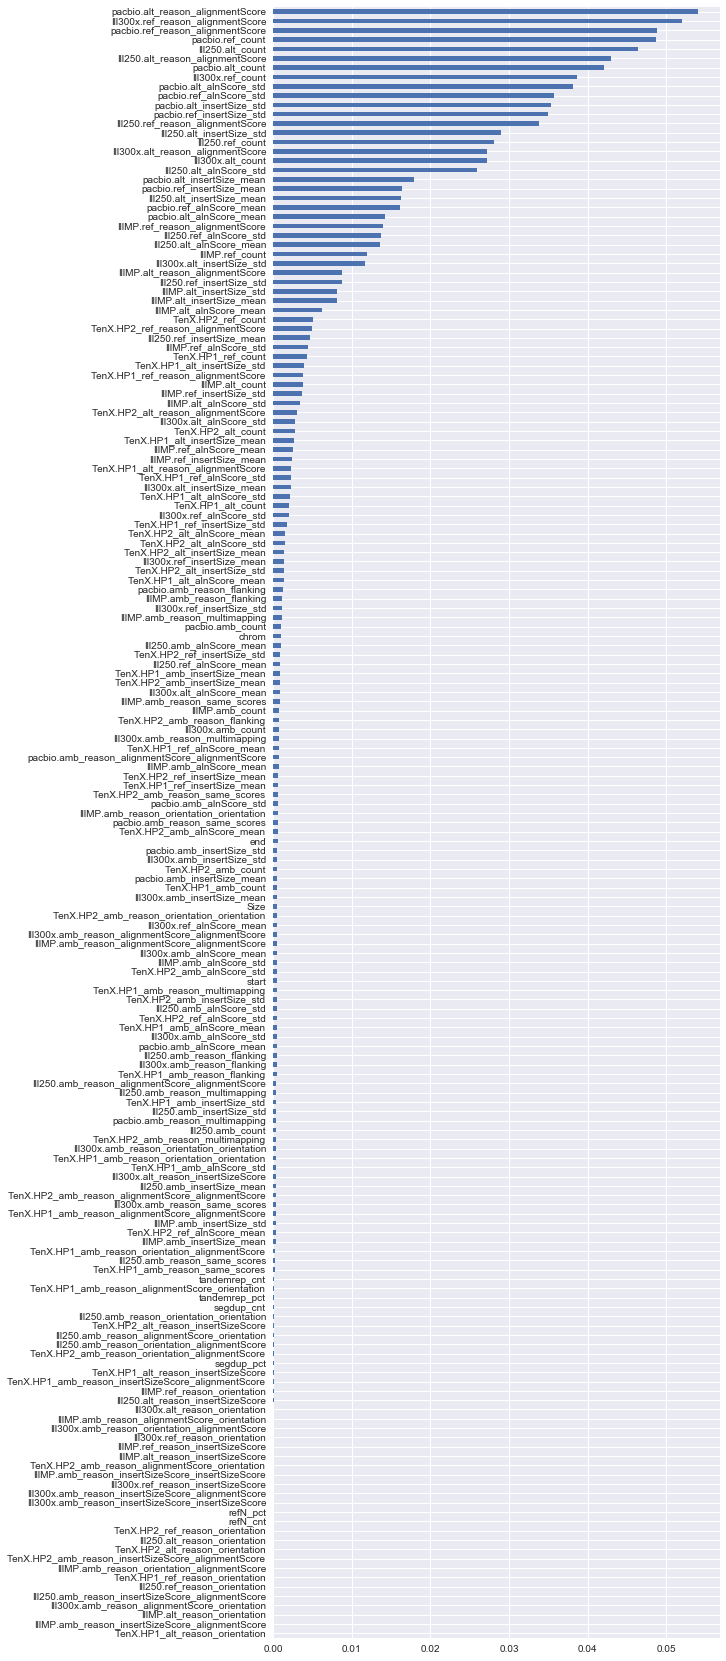

In [30]:
# %matplotlib inline
feature_importances_2 = pd.Series(model.feature_importances_, index=X_train.columns)
feature_importances_2.sort()
plt.figure(figsize=(37, 37))
# plt.savefig('/Volumes/lesleydata/SVanalyzer_ML/Oct272017_ML_w_AllTech/data/prelim_df/alldata_features_100trees_.png', bbox_inches='tight')
feature_importances_2.plot(kind="barh", figsize=(8,30))
plt.show()


In [31]:
# feature_importances.to_csv('feature_importance_500_.csv')
# feature_importances_3.to_csv('feature_importance_300_.csv')
# feature_importances_2.to_csv('feature_importance_100_.csv')

In [32]:
#TODO: Try training the model with the most important features and note difference in overal model prediction score

In [33]:
#NOTE: Training Set - Show number of Hom Ref, Hom Var, Het Var datapoints the model was trained on
ytrain = pd.DataFrame()
ytrain['ytrain'] = y_train
pd.value_counts(ytrain['ytrain'].values, sort=False)

1.0    139
2.0    144
0.0    137
dtype: int64

<a id='prediction_step'></a>

In [34]:
pred = model.predict(X_test)

<a id='traintest_precision'></a>

In [35]:
print('Precision score of the training subset: {:.3f}'.format(precision_score(y_test, pred, average='micro'))) 

Precision score of the training subset: 0.989


In [36]:
from sklearn.metrics import accuracy_score
print('Accuracy score of the training subset: {:.3f}'.format(accuracy_score(y_test, pred))) 

Accuracy score of the training subset: 0.989


In [37]:
# Add original labels and predicted labels back to the original dataframe
df_Xtest = pd.DataFrame(X_test)
df_Xtest.head()

,Ill250.alt_alnScore_mean,Ill250.alt_alnScore_std,Ill250.alt_count,Ill250.alt_insertSize_mean,Ill250.alt_insertSize_std,Ill250.alt_reason_alignmentScore,Ill250.alt_reason_insertSizeScore,Ill250.alt_reason_orientation,Ill250.amb_alnScore_mean,Ill250.amb_alnScore_std,...,pacbio.ref_insertSize_mean,pacbio.ref_insertSize_std,pacbio.ref_reason_alignmentScore,refN_cnt,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct
5,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,866.935484,121.344494,...,11311.735290,3421.676226,34.0,0.0,0.0,0.0,0.0,6248434.0,1.0,0.136000
428,934.354839,35.200393,31.0,434.645161,94.627469,31.0,0.0,0.0,873.880829,156.191995,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,123281086.0,0.0,0.000000
289,981.275862,10.569626,29.0,434.344828,59.896621,29.0,0.0,0.0,898.420118,143.612957,...,13157.909090,4137.713410,22.0,0.0,0.0,0.0,0.0,97368905.0,1.0,1.000000
16,892.800000,21.179235,5.0,414.800000,77.233154,5.0,0.0,0.0,871.968421,157.154229,...,9133.000000,0.000000,1.0,0.0,0.0,0.0,0.0,228642528.0,1.0,1.000000
26,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,903.430000,148.276044,...,9189.596491,3581.105856,57.0,0.0,0.0,0.0,0.0,18402087.0,1.0,0.033333


In [38]:
labels = pd.DataFrame(y_test)

In [39]:
df_Xtest['predicted_label'] = pred
df_Xtest['GTcons'] = df_train['GTcons']
df_Xtest['chrom'] = df_train['chrom']
df_Xtest['start'] = df_train['start']
df_Xtest['end'] = df_train['end']
# df_Xtest['Y_test'] = labels

In [40]:
df_Xtest['GTcons'].replace(0.0, 'Homozygous_Reference', inplace=True)
df_Xtest['GTcons'].replace(1.0, 'Heterozygous_Variant', inplace=True)
df_Xtest['GTcons'].replace(2.0, 'Homozygous_Variant', inplace=True)
df_Xtest['predicted_label'].replace(0.0, 'Homozygous_Reference', inplace=True)
df_Xtest['predicted_label'].replace(1.0, 'Heterozygous_Variant', inplace=True)
df_Xtest['predicted_label'].replace(2.0, 'Homozygous_Variant', inplace=True)

In [41]:
pd.value_counts(df_Xtest['GTcons'].values, sort=False)

Homozygous_Variant      56
Heterozygous_Variant    61
Homozygous_Reference    63
dtype: int64

In [42]:
pd.value_counts(df_Xtest['predicted_label'].values, sort=False)

Homozygous_Variant      56
Heterozygous_Variant    63
Homozygous_Reference    61
dtype: int64

In [43]:
from sklearn.metrics import confusion_matrix
ytest = df_Xtest['GTcons']
predict = df_Xtest['predicted_label']
print(confusion_matrix(ytest, predict))

[[61  0  0]
 [ 2 61  0]
 [ 0  0 56]]


<a id='traintest_confusion_matrix'></a>

In [44]:
pd.crosstab(ytest, predict, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Heterozygous_Variant,Homozygous_Reference,Homozygous_Variant,All
True,,,,
Heterozygous_Variant,61,0,0,61
Homozygous_Reference,2,61,0,63
Homozygous_Variant,0,0,56,56
All,63,61,56,180


In [45]:
from sklearn.metrics import classification_report
print(classification_report(ytest, predict))

                      precision    recall  f1-score   support

Heterozygous_Variant       0.97      1.00      0.98        61
Homozygous_Reference       1.00      0.97      0.98        63
  Homozygous_Variant       1.00      1.00      1.00        56

         avg / total       0.99      0.99      0.99       180



***
Predict
***

<a id='predict'></a>

Description:

   * In the [previous section](#machine_learning), a RF model was trained on svanalyzer data.

       * The model was trained using [train/test split](#train_test) where 70% of the data was used to train the model and the model performance was determined by predicting labels for the remaining 30% of the data
 * Reminder: The labels for this training set and the following [prediction step](#prediction_step) are the consensus genotype (GTcons) labels generated from a preliminary R analysis based on reference and alternate read count:
           * Homozygous Reference (0)
           * Heterozygous Variant (1)
           * Homozygous Variant (2)
           
   * The trained model is used in the following section to predict labels for 5000 randomly selected Deletions [these datapoints were randomly selected from [union_170509_refalt.sort.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/)]
   
   

** Load Data **

In [46]:
X2 = df_test

** Impute missing values using KNN **

In [48]:
#Convert dataframe to matrix
X2=X2.as_matrix()
X2=pd.DataFrame(X2)

# Imput missing values from three closest observations
X2_imputed=KNN(k=3).complete(X2)
X2=pd.DataFrame(X2_imputed)

Imputing row 1/4041 with 1 missing, elapsed time: 16.955
Imputing row 101/4041 with 1 missing, elapsed time: 16.966
Imputing row 201/4041 with 1 missing, elapsed time: 16.974
Imputing row 301/4041 with 1 missing, elapsed time: 16.983
Imputing row 401/4041 with 1 missing, elapsed time: 16.996
Imputing row 501/4041 with 1 missing, elapsed time: 17.007
Imputing row 601/4041 with 1 missing, elapsed time: 17.018
Imputing row 701/4041 with 1 missing, elapsed time: 17.026
Imputing row 801/4041 with 57 missing, elapsed time: 17.051
Imputing row 901/4041 with 1 missing, elapsed time: 17.082
Imputing row 1001/4041 with 1 missing, elapsed time: 17.090
Imputing row 1101/4041 with 1 missing, elapsed time: 17.104
Imputing row 1201/4041 with 1 missing, elapsed time: 17.113
Imputing row 1301/4041 with 29 missing, elapsed time: 17.121
Imputing row 1401/4041 with 1 missing, elapsed time: 17.133
Imputing row 1501/4041 with 1 missing, elapsed time: 17.142
Imputing row 1601/4041 with 57 missing, elapsed ti

**NOTE: Error above notes that there are no missing values **

In [49]:
dftest_header = list(df_test.columns.values)
X2.columns = dftest_header
X2.head(3)

,chrom,Size,start,end,Ill250.alt_alnScore_mean,Ill250.alt_alnScore_std,Ill250.alt_count,Ill250.alt_insertSize_mean,Ill250.alt_insertSize_std,Ill250.alt_reason_alignmentScore,...,pacbio.ref_count,pacbio.ref_insertSize_mean,pacbio.ref_insertSize_std,pacbio.ref_reason_alignmentScore,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct
0,1.0,-115.0,37568322.0,37568587.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,31.0,8407.903226,4770.945293,31.0,0.0,0.0,0.0,0.000000,3.0,0.818868
1,1.0,-2534.0,112835104.0,112837661.0,942.288889,19.746867,45.0,498.422222,83.528435,36.0,...,2.0,7826.000000,4015.000000,2.0,0.0,0.0,1.0,0.890888,6.0,0.460305
2,1.0,-40.0,1092675.0,1092715.0,952.285714,30.564752,7.0,463.142857,87.950357,7.0,...,22.0,11561.909090,4027.216667,22.0,0.0,0.0,0.0,0.000000,1.0,1.000000


In [50]:
X3 = pd.DataFrame()
X3 = X2
X3.head(3)

,chrom,Size,start,end,Ill250.alt_alnScore_mean,Ill250.alt_alnScore_std,Ill250.alt_count,Ill250.alt_insertSize_mean,Ill250.alt_insertSize_std,Ill250.alt_reason_alignmentScore,...,pacbio.ref_count,pacbio.ref_insertSize_mean,pacbio.ref_insertSize_std,pacbio.ref_reason_alignmentScore,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct
0,1.0,-115.0,37568322.0,37568587.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,31.0,8407.903226,4770.945293,31.0,0.0,0.0,0.0,0.000000,3.0,0.818868
1,1.0,-2534.0,112835104.0,112837661.0,942.288889,19.746867,45.0,498.422222,83.528435,36.0,...,2.0,7826.000000,4015.000000,2.0,0.0,0.0,1.0,0.890888,6.0,0.460305
2,1.0,-40.0,1092675.0,1092715.0,952.285714,30.564752,7.0,463.142857,87.950357,7.0,...,22.0,11561.909090,4027.216667,22.0,0.0,0.0,0.0,0.000000,1.0,1.000000


In [51]:
# Order features
X5 = X2.reindex_axis(sorted(X2.columns), axis=1)

<a id='prediction_step'></a>

In [ ]:
pred = model.predict(X5)

In [ ]:
pred_prob = model.predict_proba(X5)

In [ ]:
pred_prob_log = model.predict_log_proba(X5)

In [ ]:
X5['predicted_label'] = pred
X5['chrom'] = df_test_2['chrom']
X5['GTcons'] = df_test_2['GTcons']
X5['start'] = df_test_2['start']
X5['end'] = df_test_2['end']
X5['Size'] = df_test_2['Size']
# X5['GTconswithoutIll300x.GT'] = df_test_2['GTconswithoutIll300x.GT']
X5['GTsupp'] = df_test_2['GTsupp']

In [ ]:
X6 = pd.concat([X5, pd.DataFrame(pred_prob, columns=['1','2','3'])])

In [ ]:
X7 = pd.concat([X5, pd.DataFrame(pred_prob_log, columns=['1','2','3'])])

In [ ]:
X6.to_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct272017_ML_w_AllTech/data/prelim_df/alldata_pred_prob_DEL_100trees.csv', index=False)

In [ ]:
X7.to_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct272017_ML_w_AllTech/data/prelim_df/alldata_pred_prob_log_DEL_100trees.csv', index=False)

In [ ]:
#Note: Reformat X6 csv

In [52]:
X6 = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct272017_ML_w_AllTech/data/prelim_df/alldata_pred_prob_DEL_100trees.csv')


In [53]:
X6.rename(columns={'1': 'Homozygous_Reference_GTcons'}, inplace=True)
X6.rename(columns={'2': 'Heterozygous_Variant_GTcons'}, inplace=True)
X6.rename(columns={'3': 'Homozygous_Variant_GTcons'}, inplace=True)
X6.rename(columns={'predicted_label': 'predicted_GTcons_label'}, inplace=True)

In [ ]:
X6.head(3)

In [ ]:
X6.to_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct272017_ML_w_AllTech/data/final_df/alldata_final_GTcons_df_DEL_SVanalyzer_100trees.csv', index=False)

***
Label Analysis
***

Description:
  * The [random forest(RF) model](#train_test) was trained on svanalyzer data. The trained model was used to predict consensus GT labels for the 5000 deletions that were randomly selected from the union_refalt vcf. The following is a comparison of model predicted labels [Conesus GT] to consensus genotype generated by the R script for the 5000 randomly selected datapoints from union_refalt.vcf 

In [ ]:
from sklearn.metrics import confusion_matrix
consensus_GT = X6['GTcons']
predict = X6['predicted_GTcons_label']
print(confusion_matrix(consensus_GT, predict))

In [ ]:
X6['GTcons'].replace(0, 'Homozygous_Reference', inplace=True)
X6['GTcons'].replace(1, 'Heterozygous_Variant', inplace=True)
X6['GTcons'].replace(2, 'Homozygous_Variant', inplace=True)
X6['predicted_GTcons_label'].replace(0.0, 'Homozygous_Reference', inplace=True)
X6['predicted_GTcons_label'].replace(1.0, 'Heterozygous_Variant', inplace=True)
X6['predicted_GTcons_label'].replace(2.0, 'Homozygous_Variant', inplace=True)

<a id='predict_precision_score_matrix'></a>

In [ ]:
print('Precision score of the prediction subset: {:.3f}'.format(precision_score(consensus_GT, predict, average='micro'))) 

In [ ]:
pd.crosstab(consensus_GT, predict, rownames=['True'], colnames=['Predicted'], margins=True)

** High Confidence Label Analysis**
* **Reminder:** The labels predicted by the model are the following consensus genotype:
    * Homozygous Reference: 0 
    * Heterozygous Variant: 1 
    * Homozygous Variant: 2 
* Here **high confidence labels** are the GTcons labels predicted by the model that were also assigned a predict probability of either 0.9 or 1


In [ ]:
high_conf_labels = X6[(X6['Homozygous_Reference_GTcons'] == 1) | (X6['Homozygous_Reference_GTcons'] >= 0.9) | (X6['Heterozygous_Variant_GTcons'] == 1) | (X6['Heterozygous_Variant_GTcons'] >= 0.9) | (X6['Homozygous_Variant_GTcons'] == 1) | (X6['Homozygous_Variant_GTcons'] >= 0.9)]


<a id='hiconf_precision_score'></a>

In [ ]:
consensus_GT = high_conf_labels['GTcons']
predict = high_conf_labels['predicted_GTcons_label']
pd.crosstab(consensus_GT, predict, rownames=['True'], colnames=['Predicted'], margins=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(consensus_GT, predict))

** Anomaly Detection - SVM**

In [113]:
# Order features
X5 = X2.reindex_axis(sorted(X2.columns), axis=1)

In [114]:
clf = svm.OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1)
clf.fit(X5)
pred = clf.predict(X5)

# inliers are labeled 1, outliers are labeled -1
normal = X5[pred == 1]
abnormal = X5[pred == -1]

In [115]:
abnormal.shape

(578, 175)

In [116]:
#Plot

In [117]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
df_std = StandardScaler().fit_transform(normal)
df_std.shape

(3463, 175)

In [118]:
clf = PCA(0.95)
X_tran = clf.fit_transform(df_std)
print('Number of components that explain 95% of the variance: {:.1f}'.format(clf.n_components_)) 

Number of components that explain 95% of the variance: 86.0


In [119]:
ncomps = 86
pca=PCA(n_components=ncomps)
Y = pca.fit_transform(df_std)
dfpca = pd.DataFrame(Y, columns=['c{}'.format(c) for c in range(ncomps)], index=normal.index)
tsne = TSNE(n_components=2, random_state=0)
Z = tsne.fit_transform(dfpca)
dftsne_norm = pd.DataFrame(Z, columns=['x','y'], index=dfpca.index)

In [120]:
X5['outliers'] = pred

In [121]:
dftsne_norm['outliers'] = 1
dftsne_norm.shape

(3463, 3)

In [122]:
df_std = StandardScaler().fit_transform(abnormal)
df_std.shape
clf = PCA(0.95)
X_tran = clf.fit_transform(df_std)
print('Number of components that explain 95% of the variance: {:.1f}'.format(clf.n_components_)) 

Number of components that explain 95% of the variance: 74.0


In [123]:
ncomps = 74
pca=PCA(n_components=ncomps)
Y = pca.fit_transform(df_std)
dfpca = pd.DataFrame(Y, columns=['c{}'.format(c) for c in range(ncomps)], index=abnormal.index)
tsne = TSNE(n_components=2, random_state=0)
Z = tsne.fit_transform(dfpca)
dftsne_abnorm = pd.DataFrame(Z, columns=['x','y'], index=dfpca.index)

In [124]:
dftsne_abnorm['outliers'] = -1
dftsne_abnorm.shape

(578, 3)

In [125]:
plot_ = pd.concat([dftsne_abnorm, dftsne_norm], axis=0)
plot_.shape

(4041, 3)

In [126]:
normal = plot_[plot_['outliers'] == 1]
abnormal = plot_[plot_['outliers'] == -1]

In [127]:
abnormal.shape

(578, 3)

In [128]:
plot_['Homozygous_Reference_GTcons'] = X6['Homozygous_Reference_GTcons']
plot_['Heterozygous_Variant_GTcons'] = X6['Heterozygous_Variant_GTcons']
plot_['Homozygous_Variant_GTcons'] = X6['Homozygous_Variant_GTcons']
plot_['predicted_GTcons_label'] = X6['predicted_GTcons_label']

In [129]:
# Abnormal : Predict probability plot

In [130]:
abnormal_plt = plot_[plot_['outliers'] == -1]

In [131]:
#Find the max across multiple rows
abnormal_plt['max_predprob'] = abnormal_plt[['Homozygous_Reference_GTcons', 'Heterozygous_Variant_GTcons', 'Homozygous_Variant_GTcons']].max(axis=1)

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [132]:
output_notebook()

Loading BokehJS ...

In [133]:
p=Histogram(abnormal_plt,values='max_predprob',title='SVM Outlier : Predict Probability',color='LightSlateGray',bins=30,xlabel="Predict Probability",ylabel="Frequency")
show(p)

In [134]:
# Normal : Predict probability plot

In [135]:
normal_plt = plot_[plot_['outliers'] == 1]

In [136]:
plot_['Homozygous_Reference_GTcons'] = X6['Homozygous_Reference_GTcons']
plot_['Heterozygous_Variant_GTcons'] = X6['Heterozygous_Variant_GTcons']
plot_['Homozygous_Variant_GTcons'] = X6['Homozygous_Variant_GTcons']
plot_['predicted_GTcons_label'] = X6['predicted_GTcons_label']

In [137]:
#Find the max across multiple rows
normal_plt['max_predprob'] = normal_plt[['Homozygous_Reference_GTcons', 'Heterozygous_Variant_GTcons', 'Homozygous_Variant_GTcons']].max(axis=1)

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [138]:
output_notebook()

Loading BokehJS ...

In [139]:
p=Histogram(normal_plt,values='max_predprob',title='SVM Normal : Predict Probability',color='LightSlateGray',bins=30,xlabel="Predict Probability",ylabel="Frequency")
show(p)

In [140]:
bins = [0, 0.5, 0.8,0.9,1]
group_names_size = ['0-0.5', '0.5-0.8', '0.8-0.9', '0.9-1']
abnormal_plt['predprob_bin'] = pd.cut(abnormal_plt['max_predprob'], bins, labels=group_names_size)

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [141]:
# plt.figure()
# plt.plot(normal['x'],normal['y'],'8')
# plt.plot(abnormal['x'],abnormal['y'],'ro')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.show()

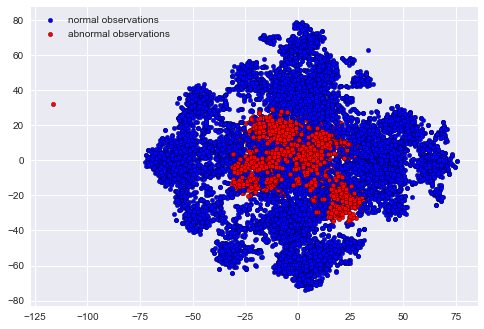

In [142]:
a = plt.scatter(normal['x'],normal['y'], c='blue',
                edgecolor='k', s=20)
b = plt.scatter(abnormal['x'],abnormal['y'], c='red',
                edgecolor='k', s=20)
plt.axis('tight')
plt.legend([a, b],
           ["normal observations",
            "abnormal observations"],
           loc="upper left")
plt.savefig('/Volumes/lesleydata/SVanalyzer_ML/Oct272017_ML_w_AllTech/data/prelim_df/svm_outliers.png', bbox_inches='tight')

** Anomaly Detection - Local Outlier Factor**

[LOF](http://scikit-learn.org/stable/auto_examples/neighbors/plot_lof.html#sphx-glr-auto-examples-neighbors-plot-lof-py)

In [143]:
# Order features
X5 = X2.reindex_axis(sorted(X2.columns), axis=1)

In [144]:
clf = LocalOutlierFactor(n_neighbors=20)
pred = clf.fit_predict(X5)

# inliers are labeled 1, outliers are labeled -1
normal = X5[pred == 1]
abnormal = X5[pred == -1]

In [145]:
abnormal.shape

(405, 175)

In [146]:
df_std = StandardScaler().fit_transform(normal)
df_std.shape

(3636, 175)

In [147]:
clf = PCA(0.95)
X_tran = clf.fit_transform(df_std)
print('Number of components that explain 95% of the variance: {:.1f}'.format(clf.n_components_)) 

Number of components that explain 95% of the variance: 85.0


In [148]:
ncomps = 86
pca=PCA(n_components=ncomps)
Y = pca.fit_transform(df_std)
dfpca = pd.DataFrame(Y, columns=['c{}'.format(c) for c in range(ncomps)], index=normal.index)
tsne = TSNE(n_components=2, random_state=0)
Z = tsne.fit_transform(dfpca)
dftsne_norm = pd.DataFrame(Z, columns=['x','y'], index=dfpca.index)

In [149]:
X5['outliers'] = pred

In [150]:
dftsne_norm['outliers'] = 1
dftsne_norm.shape

(3636, 3)

In [151]:
df_std = StandardScaler().fit_transform(abnormal)
df_std.shape
clf = PCA(0.95)
X_tran = clf.fit_transform(df_std)
print('Number of components that explain 95% of the variance: {:.1f}'.format(clf.n_components_)) 

Number of components that explain 95% of the variance: 67.0


In [152]:
ncomps = 68
pca=PCA(n_components=ncomps)
Y = pca.fit_transform(df_std)
dfpca = pd.DataFrame(Y, columns=['c{}'.format(c) for c in range(ncomps)], index=abnormal.index)
tsne = TSNE(n_components=2, random_state=0)
Z = tsne.fit_transform(dfpca)
dftsne_abnorm = pd.DataFrame(Z, columns=['x','y'], index=dfpca.index)

In [153]:
dftsne_abnorm['outliers'] = -1
dftsne_abnorm.shape

(405, 3)

In [154]:
plot_ = pd.concat([dftsne_abnorm, dftsne_norm], axis=0)
plot_.shape

(4041, 3)

In [155]:
normal = plot_[plot_['outliers'] == 1]
abnormal = plot_[plot_['outliers'] == -1]

In [156]:
abnormal.shape

(405, 3)

In [157]:
# plt.figure()
# plt.plot(normal['x'],normal['y'],'8')
# plt.plot(abnormal['x'],abnormal['y'],'ro')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.show()

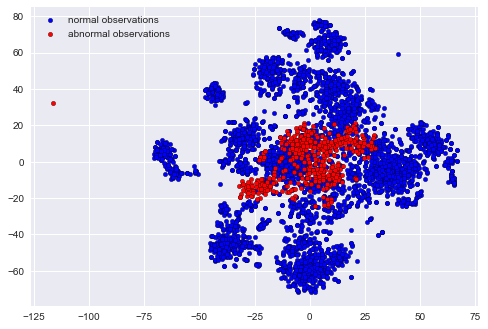

In [158]:
a = plt.scatter(normal['x'],normal['y'], c='blue',
                edgecolor='k', s=20)
b = plt.scatter(abnormal['x'],abnormal['y'], c='red',
                edgecolor='k', s=20)
plt.axis('tight')
plt.legend([a, b],
           ["normal observations",
            "abnormal observations"],
           loc="upper left")
plt.show()

In [159]:
plot_['Homozygous_Reference_GTcons'] = X6['Homozygous_Reference_GTcons']
plot_['Heterozygous_Variant_GTcons'] = X6['Heterozygous_Variant_GTcons']
plot_['Homozygous_Variant_GTcons'] = X6['Homozygous_Variant_GTcons']
plot_['predicted_GTcons_label'] = X6['predicted_GTcons_label']

In [160]:
# Abnormal : Predict probability plot

In [161]:
abnormal_plt = plot_[plot_['outliers'] == -1]

In [162]:
#Find the max across multiple rows
abnormal_plt['max_predprob'] = abnormal_plt[['Homozygous_Reference_GTcons', 'Heterozygous_Variant_GTcons', 'Homozygous_Variant_GTcons']].max(axis=1)

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [163]:
output_notebook()

Loading BokehJS ...

In [164]:
p=Histogram(abnormal_plt,values='max_predprob',title='LOF Outliers : Abnormal Predict Probability',color='LightSlateGray',bins=30,xlabel="Predict Probability",ylabel="Frequency")
show(p)
plt.savefig('/Volumes/lesleydata/SVanalyzer_ML/Oct272017_ML_w_AllTech/data/prelim_df/LOF_outliers.png', bbox_inches='tight')

In [165]:
# Normal : Predict probability plot

In [166]:
normal_plt = plot_[plot_['outliers'] == 1]

In [167]:
#Find the max across multiple rows
normal_plt['max_predprob'] = normal_plt[['Homozygous_Reference_GTcons', 'Heterozygous_Variant_GTcons', 'Homozygous_Variant_GTcons']].max(axis=1)

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [168]:
output_notebook()

Loading BokehJS ...

In [169]:
p=Histogram(normal_plt,values='max_predprob',title='LOF Normal: Predict Probability',color='LightSlateGray',bins=30,xlabel="Predict Probability",ylabel="Frequency")
show(p)